In [1]:
import sys
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from accelerate import Accelerator
from accelerate.utils import set_seed, ProjectConfiguration, LoggerType
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
# Add project root to sys.path
project_root = os.path.abspath("/workspace/meteolibre_model/")
sys.path.insert(0, project_root)


from meteolibre_model.dataset.dataset import MeteoLibreMapDataset
from meteolibre_model.models.dc_3dunet_film import UNet_DCAE_3D


In [ ]:
!pip install matplotlib

In [2]:
# Initialize dataset
dataset = MeteoLibreMapDataset(
    localrepo="/workspace/data/data",  # Replace with your dataset path
    cache_size=8,
    seed=42,
)

In [3]:
dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        num_workers=1, #os.cpu_count() // 2,  # Use half the available CPUs
        pin_memory=True,
    )



In [4]:
for batch in dataloader:
    break

In [5]:
import torch

import numpy as np
import scipy.fft
from PIL import Image


from meteolibre_model.diffusion.utils import MEAN_CHANNEL, STD_CHANNEL



# The model expects (BATCH, NB_CHANNEL, NB_TEMPORAL, H, W), so permute dimensions
batch_data = batch["patch_data"].permute(0, 2, 1, 3, 4)

# normalize using MEAN and STD
batch_data = (
    batch_data.to("cuda") - MEAN_CHANNEL.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to("cuda")
) / STD_CHANNEL.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to("cuda")

# garde fou
batch_data = batch_data.clamp(-7, 7)

x_context = batch_data[:, :, :4]  # Shape: (BATCH, NB_CHANNEL, 4, H, W)
x_target = batch_data[:, :, 4:]  # This is x_0, shape: (BATCH, NB_CHANNEL, 2, H, W)



tensor(2.7977, device='cuda:0')
tensor(2.7959, device='cuda:0')
tensor(2.7908, device='cuda:0')
tensor(2.7865, device='cuda:0')
tensor(2.7803, device='cuda:0')
tensor(2.7749, device='cuda:0')


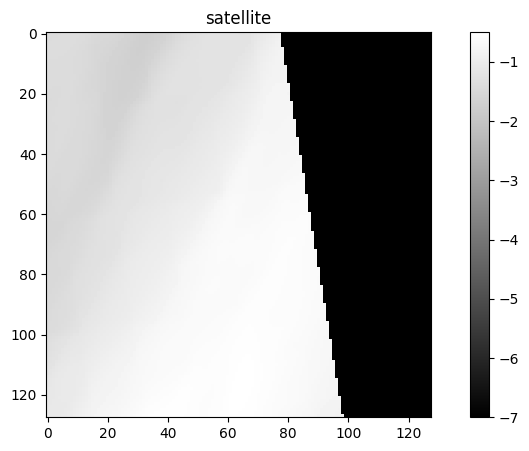

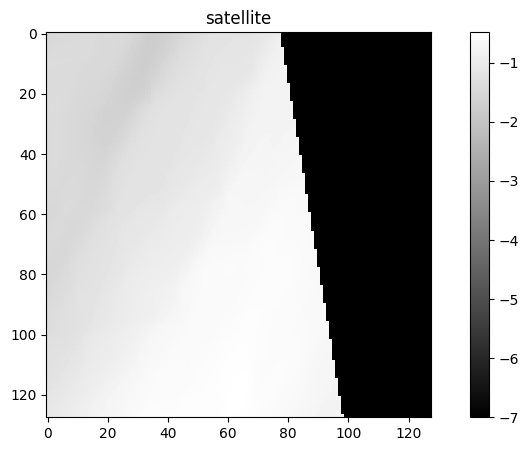

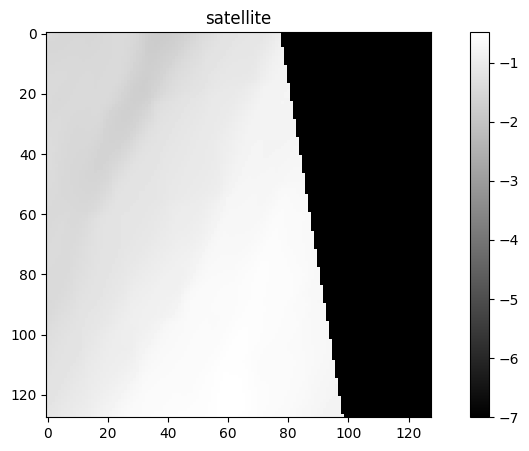

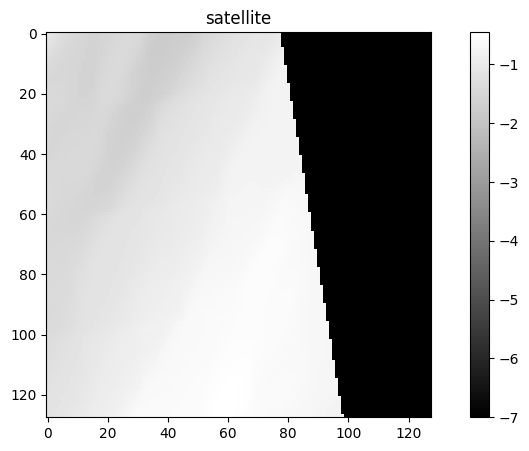

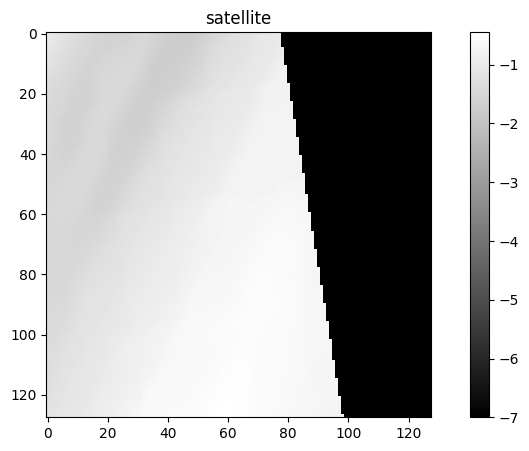

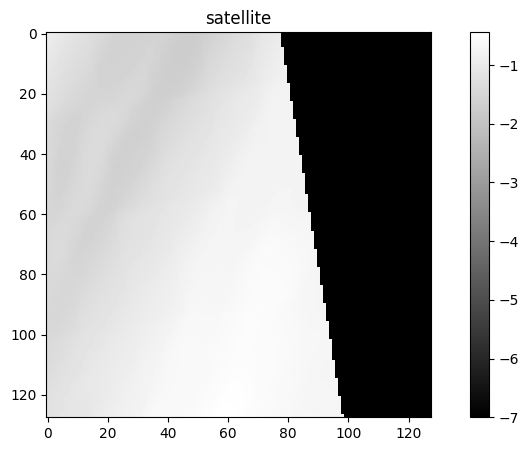

In [8]:

for i in range(6):
    sat = batch_data[0, -2, i, :, :]
    print(batch_data[0, -2, i, :, :].std())
    plt.figure(figsize=(10, 5))
    plt.imshow(sat.cpu().numpy(), cmap='gray')
    plt.title('satellite')
    plt.colorbar()

In [12]:
import einops
from meteolibre_model.diffusion.blurring_diffusion import apply_blur_diffusion
x_target = batch_data[:, :, 4:]  # This is x_0, shape: (BATCH, NB_CHANNEL, 2, H, W)
b = 32
# 1. Generate random timesteps for the batch
t_batch = torch.linspace(0., 1., b)

x_target = x_target[[1]]
x_target = x_target.repeat(b , 1, 1, 1, 1)

# 3. Create noisy target by applying blurring diffusion forward process
# quick permutation to manage the 4D constraint
t_subset = 2
x_target = einops.rearrange(x_target, "b c t h w -> (b t) c h w")

t_blur = t_batch.unsqueeze(1).repeat(1, t_subset)
t_blur = einops.rearrange(t_blur, "b t-> (b t)")

x_t_batch, noise = apply_blur_diffusion(x_target, t_blur, sigma_b_max=0.)

x_t_batch = einops.rearrange(x_t_batch, "(b t) c h w -> b c t h w", b=b, t=t_subset)



In [13]:
x_target.shape

torch.Size([64, 12, 128, 128])

/tmp/ipykernel_132246/3533674126.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


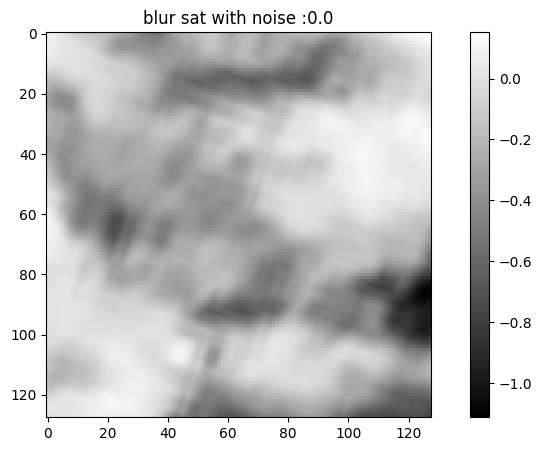

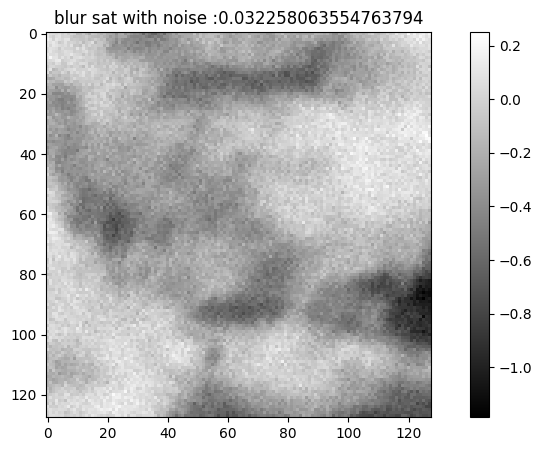

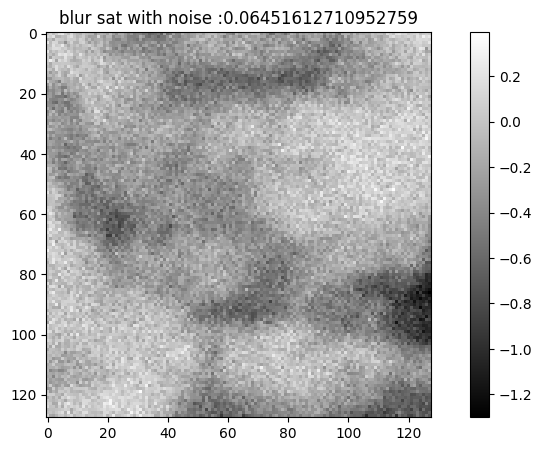

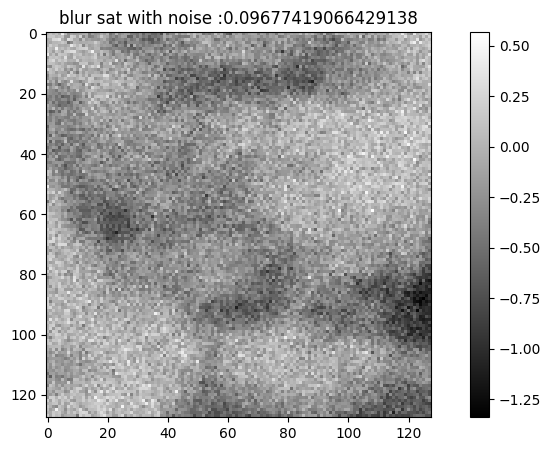

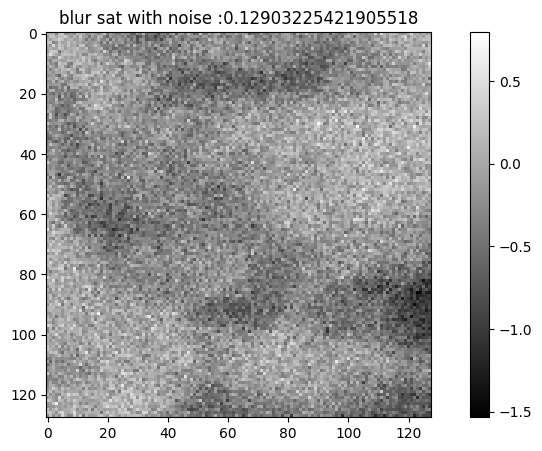

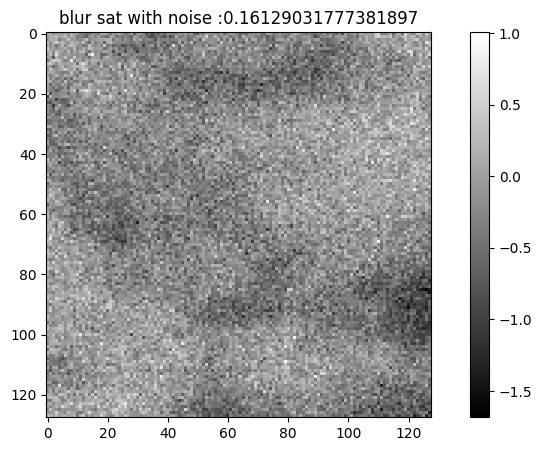

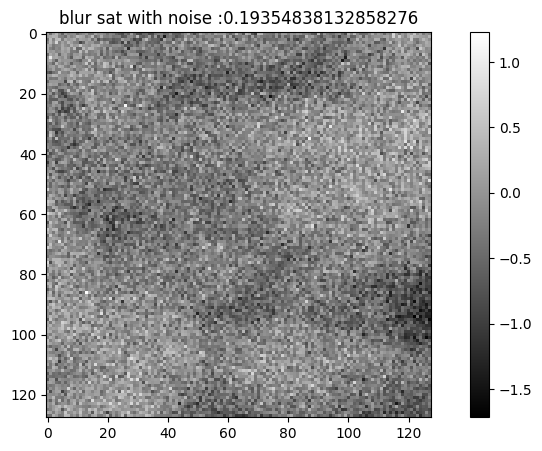

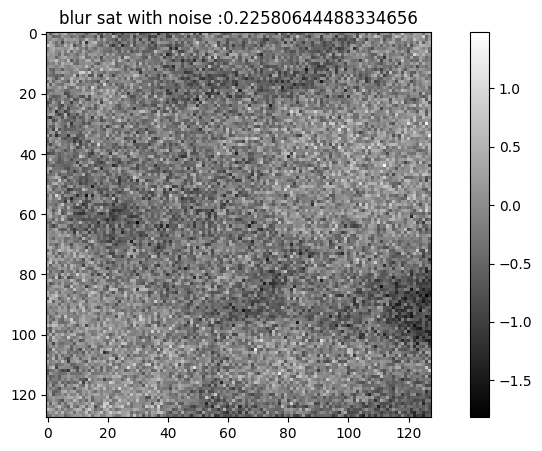

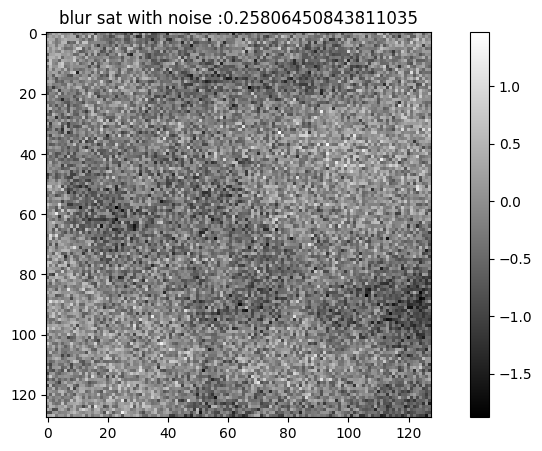

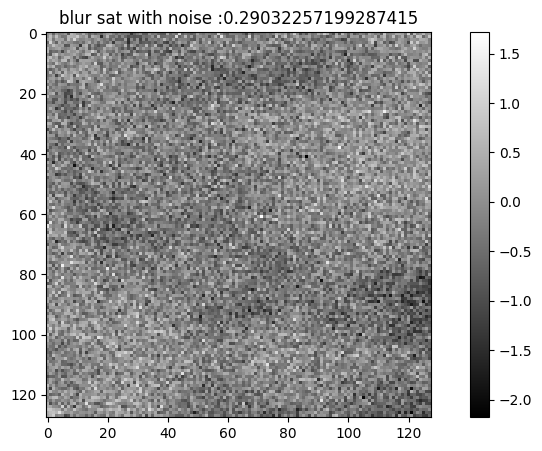

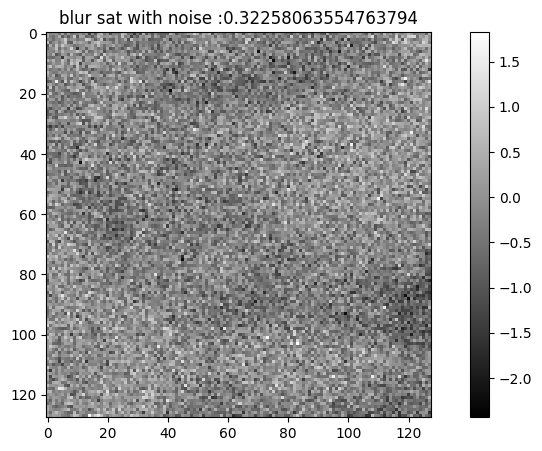

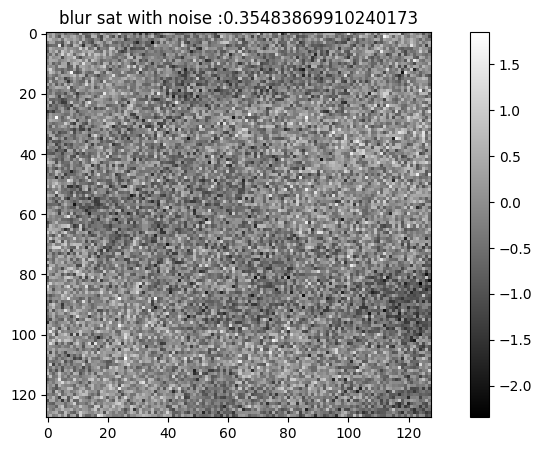

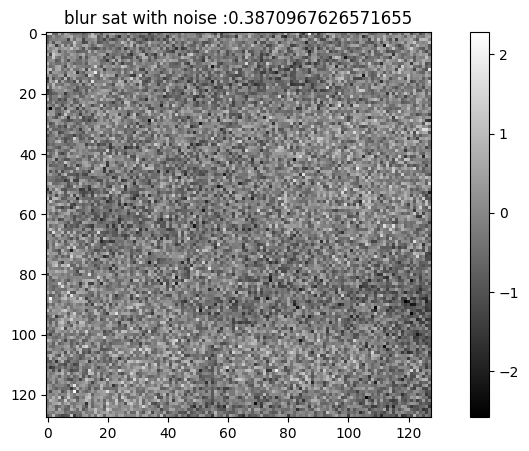

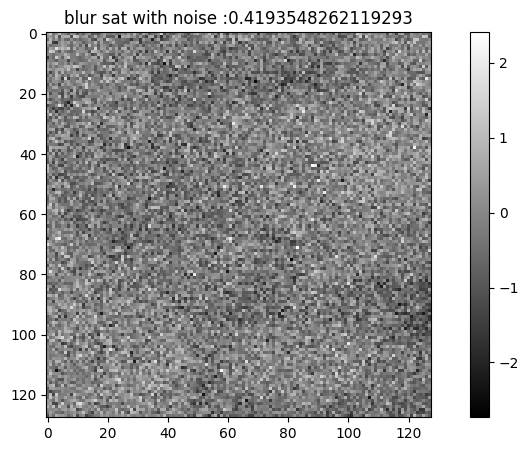

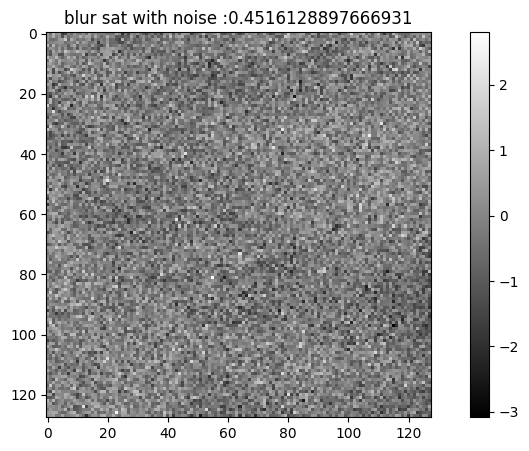

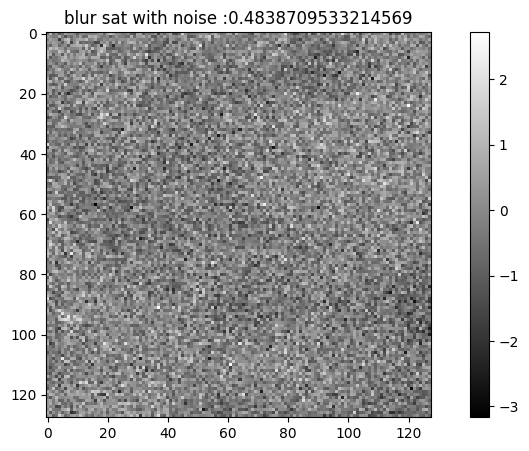

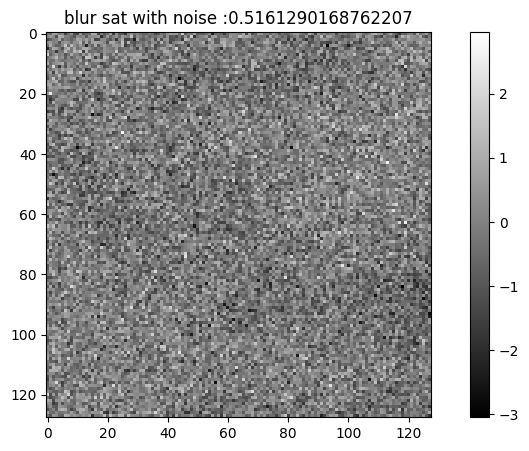

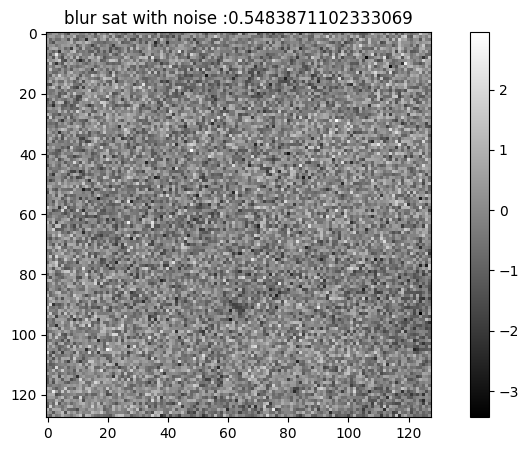

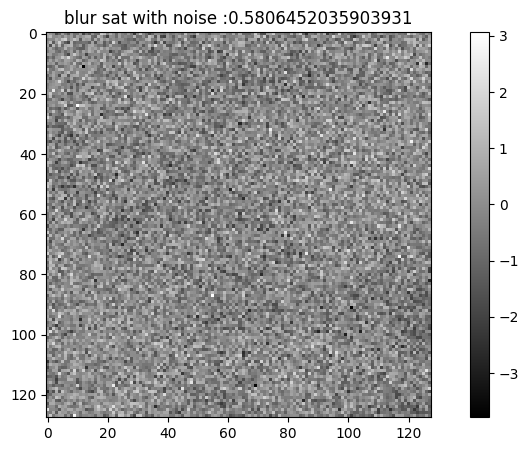

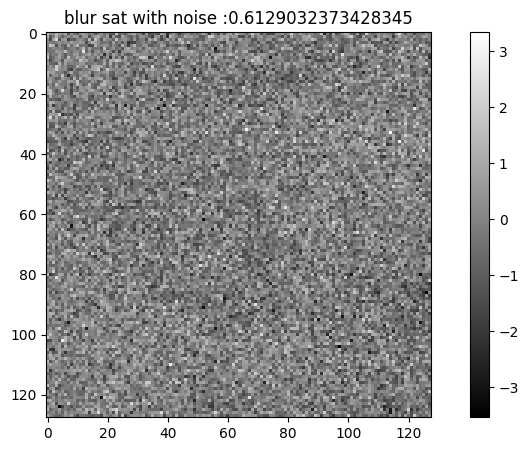

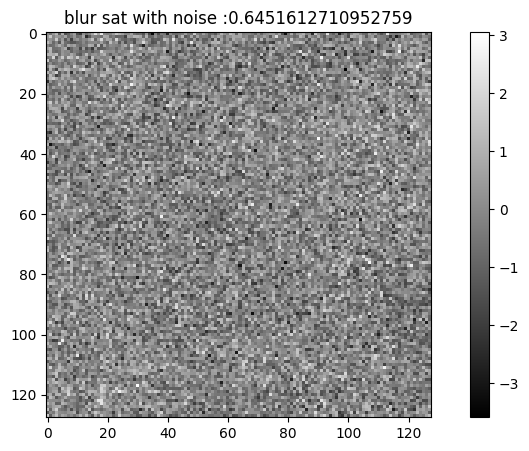

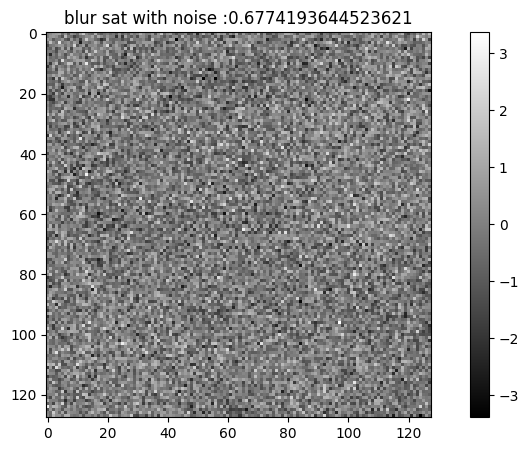

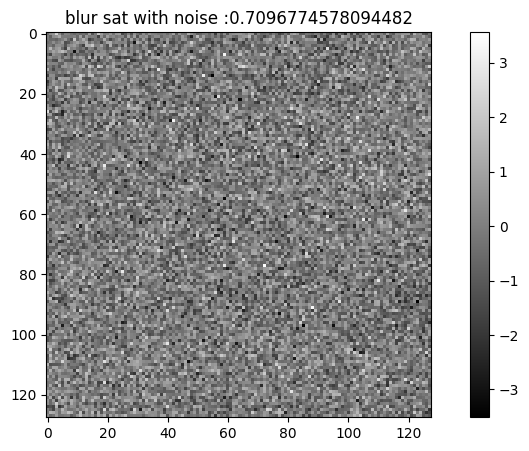

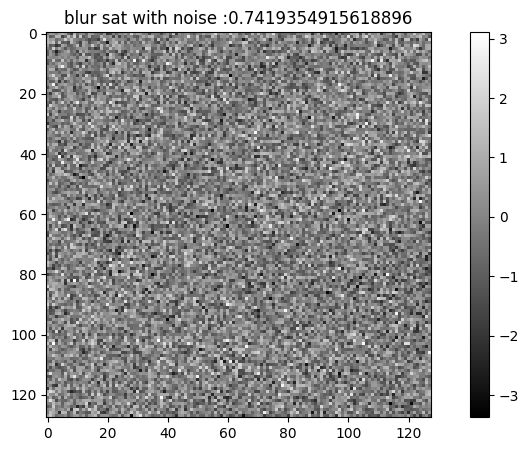

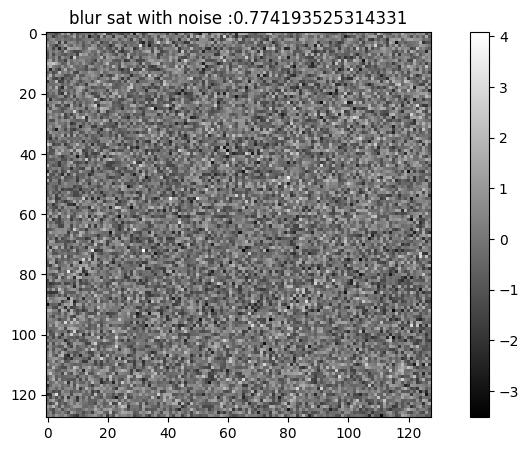

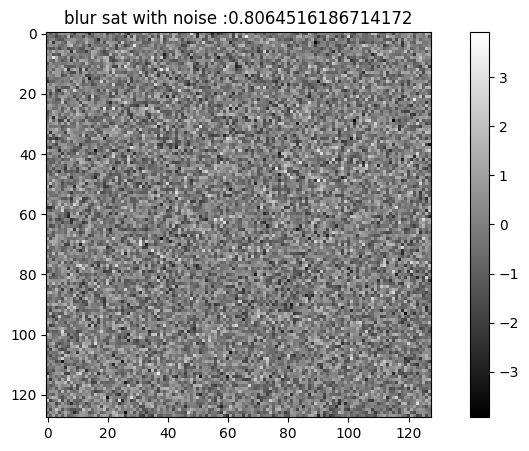

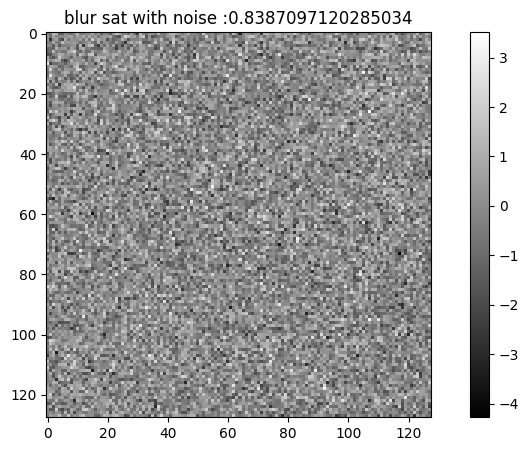

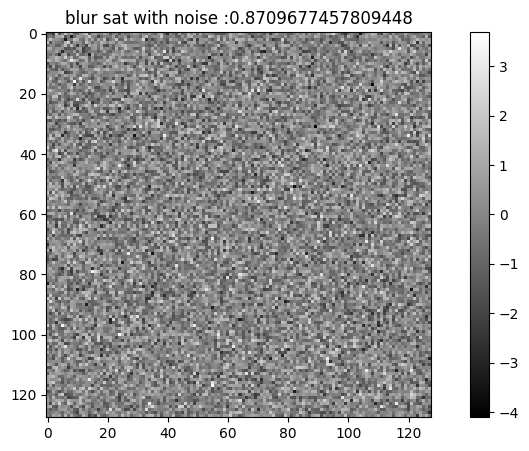

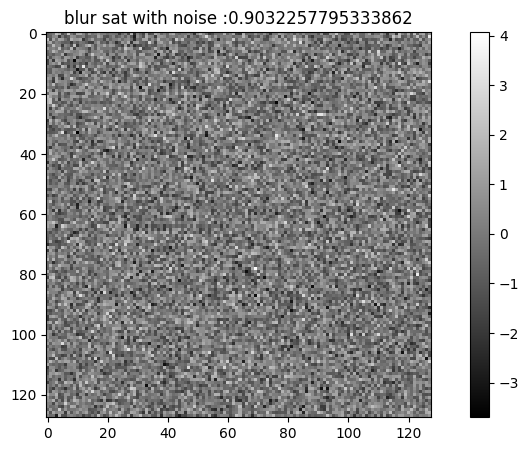

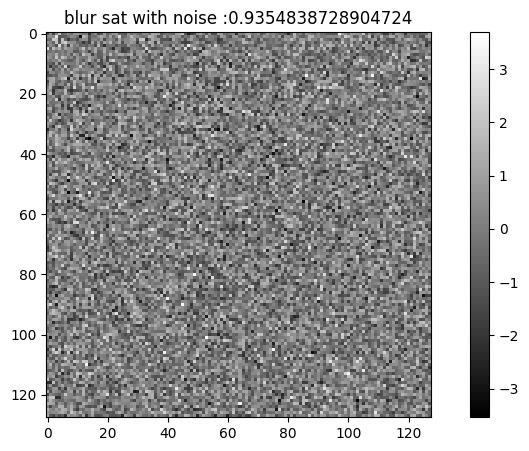

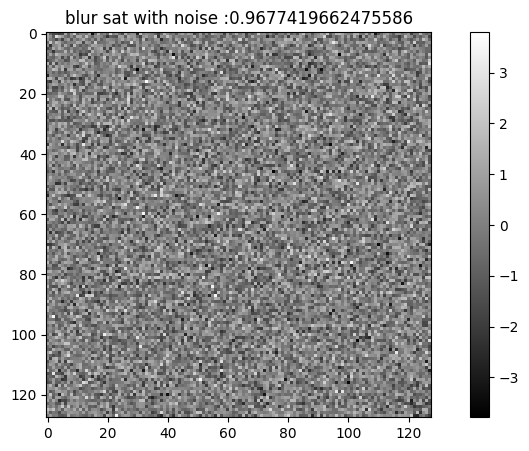

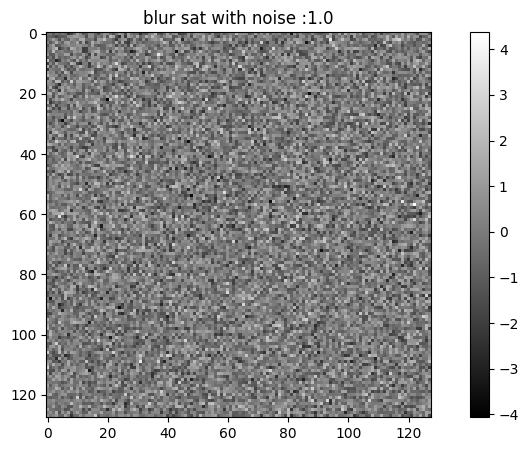

In [14]:


for t in range(32):

    plt.figure(figsize=(10, 5))
    plt.imshow(x_t_batch[t, -1, 0, :, :].cpu().numpy(), cmap='gray')

    plt.title('blur sat with noise :' + str(t_batch[t].item()))
    plt.colorbar()

In [20]:
x_t_batch.shape

torch.Size([8, 12, 2, 128, 128])